# Experimental Evaluation Figures
This notebook aggregates all benchmarking workflows to reproduce the figures and plots for the experimental evaluation section of [Littau_QuASAr.pdf](../../Littau_QuASAr.pdf).

## Imported from `00_environment_setup.ipynb`

# Environment Setup

This notebook captures system information for benchmarking and saves it to `environment.json`.


In [ ]:
import json, platform, subprocess, psutil, numpy as np
from pathlib import Path

info = {}
info['cpu_model'] = next((l.split(':',1)[1].strip() for l in open('/proc/cpuinfo') if 'model name' in l), platform.processor())
info['cpu_count'] = psutil.cpu_count()
info['ram_gb'] = round(psutil.virtual_memory().total / 1024**3, 2)
info['os'] = platform.platform()
info['python_version'] = platform.python_version()
info['blas_libraries'] = np.__config__.get_info('blas_opt_info').get('libraries', [])
info['lapack_libraries'] = np.__config__.get_info('lapack_opt_info').get('libraries', [])
import stim, mqt.ddsim, mqt.core
info['stim_version'] = getattr(stim, '__version__', None)
info['mqt_dd_version'] = getattr(mqt.ddsim, '__version__', None)
info['mqt_core_version'] = getattr(mqt.core, '__version__', None)
try:
    import pybind11
    info['pybind11_version'] = pybind11.__version__
except Exception:
    info['pybind11_version'] = None
info['quasar_commit'] = subprocess.check_output(['git','rev-parse','HEAD']).decode().strip()
def run_cmd(cmd):
    try:
        return subprocess.check_output(cmd, text=True).splitlines()[0]
    except Exception:
        return None
info['compiler'] = run_cmd(['cc','--version']) or run_cmd(['gcc','--version'])
info['cmake_version'] = run_cmd(['cmake','--version'])
Path('environment.json').write_text(json.dumps(info, indent=2))
info


Environment information saved to `environment.json`.


## Benchmark Circuits

The table below lists benchmark circuits used in QuASAr.

In [ ]:
from benchmarks.circuits import (
    clifford_ec_circuit,
    ripple_add_circuit,
    vqe_chain_circuit,
    random_hybrid_circuit,
    recur_subroutine_circuit,
)
import inspect
from pathlib import Path
from IPython.display import Markdown


def src_link(func):
    file = Path(inspect.getsourcefile(func)).relative_to(Path.cwd())
    line = inspect.getsourcelines(func)[1]
    return f"[generator]({file}#L{line})"

circuits = [
    ("Clifford-EC", clifford_ec_circuit, "3-qubit bit-flip error correction"),
    ("Ripple-Add", ripple_add_circuit, "Ripple-carry adder for two 4-bit registers"),
    ("VQE-Chain", vqe_chain_circuit, "VQE ansatz with linear entanglement chain"),
    ("Random-Hybrid", random_hybrid_circuit, "Random mix of Clifford and T gates"),
    ("Recur-Subroutine", recur_subroutine_circuit, "Circuit with repeated subroutine layers"),
]

rows = ["| Circuit | Qubits | Gates | Description | Source |", "|---|---|---|---|---|"]
for name, fn, desc in circuits:
    circ = fn()
    rows.append(f"| {name} | {circ.num_qubits} | {circ.num_gates} | {desc} | {src_link(fn)} |")
Markdown("
".join(rows))


In [ ]:

# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple))
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f"../results/{nb_name}_params.json", 'w') as f:
    json.dump(_params, f, indent=2)
if 'results' in globals():
    try:
        with open(f"../results/{nb_name}_results.json", 'w') as f:
            json.dump(results, f, indent=2)
    except TypeError:
        pass
print(json.dumps(_params, indent=2))


## Imported from `01_microbenchmarks.ipynb`

# Microbenchmarks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from benchmarks.runner import BenchmarkRunner

In [2]:
chis = [8, 16, 32, 64, 128]
reps = 5
svd_results = []
for chi in chis:
    runner = BenchmarkRunner()
    times = []
    mems = []
    for _ in range(reps):
        mat = np.random.randn(chi, chi)
        rec = runner.run_multiple(mat, lambda m: np.linalg.svd(m, full_matrices=False), repetitions=3)
        times.append(rec['run_time_mean'])
        mems.append(rec['run_peak_memory_mean'])
    svd_results.append({
        'chi': chi,
        'mean_time': np.mean(times),
        'std_time': np.std(times),
        'mean_mem': np.mean(mems),
        'std_mem': np.std(mems)
    })
svd_df = pd.DataFrame(svd_results)
svd_df

,chi,mean_time,std_time,mean_mem,std_mem
0,8,0.000131,0.000115,2784.333333,208.666667
1,16,0.000110,0.000007,5816.000000,0.000000
2,32,0.000282,0.000036,18232.000000,0.000000
3,64,0.001184,0.000534,67640.000000,0.000000
4,128,0.004216,0.000696,264762.133333,4.266667


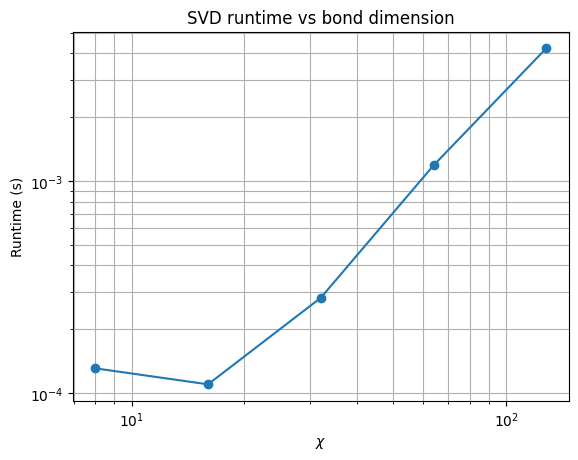

In [3]:
plt.figure()
plt.loglog(svd_df['chi'], svd_df['mean_time'], marker='o')
plt.xlabel(r'$\chi$')
plt.ylabel('Runtime (s)')
plt.title('SVD runtime vs bond dimension')
plt.grid(True, which='both')
plt.show()

In [4]:
frontiers = [10, 50, 200, 1000]
reps = 5
dd_results = []
for r in frontiers:
    runner = BenchmarkRunner()
    times = []
    mems = []
    for _ in range(reps):
        data = np.random.rand(r)
        rec = runner.run_multiple(data, lambda x: np.sort(x), repetitions=3)
        times.append(rec['run_time_mean'])
        mems.append(rec['run_peak_memory_mean'])
    dd_results.append({
        'frontier': r,
        'mean_time': np.mean(times),
        'std_time': np.std(times),
        'mean_mem': np.mean(mems),
        'std_mem': np.std(mems)
    })
dd_df = pd.DataFrame(dd_results)
dd_df

,frontier,mean_time,std_time,mean_mem,std_mem
0,10,0.000035,0.000036,2932.2,120.400000
1,50,0.000013,0.000003,3192.0,0.000000
2,200,0.000030,0.000010,4438.4,92.800000
3,1000,0.000041,0.000031,10857.4,99.939182


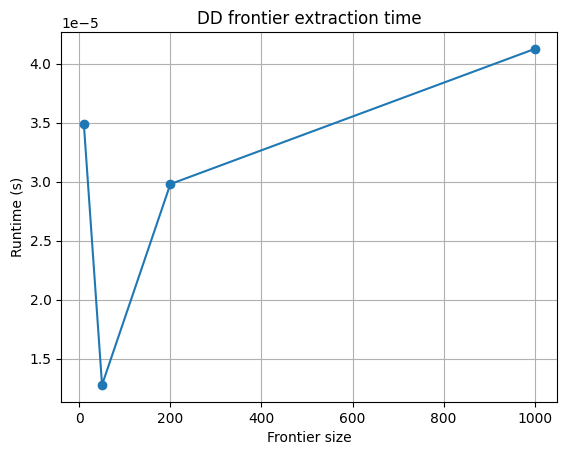

In [5]:
plt.figure()
plt.plot(dd_df['frontier'], dd_df['mean_time'], marker='o')
plt.xlabel('Frontier size')
plt.ylabel('Runtime (s)')
plt.title('DD frontier extraction time')
plt.grid(True)
plt.show()

In [6]:
windows = list(range(2, 9))
reps = 5
st_results = []
for w in windows:
    runner = BenchmarkRunner()
    times = []
    mems = []
    for _ in range(reps):
        rec = runner.run_multiple(w, lambda win: sum(range(1 << win)), repetitions=3)
        times.append(rec['run_time_mean'])
        mems.append(rec['run_peak_memory_mean'])
    st_results.append({
        'window': w,
        'mean_time': np.mean(times),
        'std_time': np.std(times),
        'mean_mem': np.mean(mems),
        'std_mem': np.std(mems)
    })
st_df = pd.DataFrame(st_results)
st_df

,window,mean_time,std_time,mean_mem,std_mem
0,2,0.000005,1.319051e-06,152.000000,0.000000
1,3,0.000004,1.074887e-07,152.000000,0.000000
2,4,0.000004,2.680126e-07,152.000000,0.000000
3,5,0.000005,2.757279e-07,152.000000,0.000000
4,6,0.000005,1.513976e-07,152.000000,0.000000
5,7,0.000006,9.680753e-07,156.266667,8.533333
6,8,0.000007,1.093086e-06,156.266667,8.533333


In [7]:
st_df

,window,mean_time,std_time,mean_mem,std_mem
0,2,0.000005,1.319051e-06,152.000000,0.000000
1,3,0.000004,1.074887e-07,152.000000,0.000000
2,4,0.000004,2.680126e-07,152.000000,0.000000
3,5,0.000005,2.757279e-07,152.000000,0.000000
4,6,0.000005,1.513976e-07,152.000000,0.000000
5,7,0.000006,9.680753e-07,156.266667,8.533333
6,8,0.000007,1.093086e-06,156.266667,8.533333


In [8]:
import pandas as pd
from benchmarks.stats_utils import stats_table

def add_stats(df, quasar_col='QuASAr', baseline_cols=None, test='ttest', correction='bonferroni'):
    """Compute statistics comparing QuASAr with baselines.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with per-circuit results. One column must correspond to QuASAr,
        others to baselines.
    quasar_col : str
        Name of the column containing QuASAr results.
    baseline_cols : list[str] | None
        Columns to treat as baselines. Defaults to all columns except quasar_col.
    test : str
        'ttest' or 'wilcoxon'.
    correction : str
        'bonferroni' or 'fdr_bh'.

    Returns
    -------
    pd.DataFrame
        Table with baseline name, statistic, corrected p-value, and effect size.
    """
    if baseline_cols is None:
        baseline_cols = [c for c in df.columns if c != quasar_col]
    baselines = {c: df[c] for c in baseline_cols}
    return stats_table(df[quasar_col], baselines, test=test, correction=correction)

# Example usage after computing results DataFrame named `results_df`:
# stats_df = add_stats(results_df)
# stats_df


In [9]:

# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple))
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f"../results/{nb_name}_params.json", 'w') as f:
    json.dump(_params, f, indent=2, default=str)
if 'results' in globals():
    try:
        with open(f"../results/{nb_name}_results.json", 'w') as f:
            json.dump(results, f, indent=2, default=str)
    except TypeError:
        pass
print(json.dumps(_params, indent=2, default=str))


{
  "In": [
    "",
    "import numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom benchmarks.runner import BenchmarkRunner",
    "chis = [8, 16, 32, 64, 128]\nreps = 5\nsvd_results = []\nfor chi in chis:\n    runner = BenchmarkRunner()\n    times = []\n    mems = []\n    for _ in range(reps):\n        mat = np.random.randn(chi, chi)\n        rec = runner.run_multiple(mat, lambda m: np.linalg.svd(m, full_matrices=False), repetitions=3)\n        times.append(rec['run_time_mean'])\n        mems.append(rec['run_peak_memory_mean'])\n    svd_results.append({\n        'chi': chi,\n        'mean_time': np.mean(times),\n        'std_time': np.std(times),\n        'mean_mem': np.mean(mems),\n        'std_mem': np.std(mems)\n    })\nsvd_df = pd.DataFrame(svd_results)\nsvd_df",
    "plt.figure()\nplt.loglog(svd_df['chi'], svd_df['mean_time'], marker='o')\nplt.xlabel(r'$\\chi$')\nplt.ylabel('Runtime (s)')\nplt.title('SVD runtime vs bond dimension')\nplt.grid(True, which='both'

## Imported from `02_end_to_end.ipynb`

# End-to-End Benchmark

Run QuASAr and baseline backends on benchmark circuits and compare performance.

In [ ]:
import os, sys
sys.path.append(os.path.abspath('../..'))
import pandas as pd
from benchmarks.runner import BenchmarkRunner
from benchmarks.backends import StatevectorAdapter, DecisionDiagramAdapter, MPSAdapter, StimAdapter
from benchmarks import circuits
from quasar.simulation_engine import SimulationEngine
from quasar_convert import ConversionEngine
import time, matplotlib.pyplot as plt

In [ ]:
class TrackingConversionEngine(ConversionEngine):
    def __init__(self):
        super().__init__()
        self.total_time = 0.0
    def _timeit(self, func, *args, **kwargs):
        start = time.perf_counter()
        res = func(*args, **kwargs)
        self.total_time += time.perf_counter() - start
        return res
    def convert_boundary_to_statevector(self, ssd):
        return self._timeit(super().convert_boundary_to_statevector, ssd)
    def convert_boundary_to_tableau(self, ssd):
        if hasattr(super(), "convert_boundary_to_tableau"):
            return self._timeit(super().convert_boundary_to_tableau, ssd)
        raise AttributeError
    def convert_boundary_to_dd(self, ssd):
        if hasattr(super(), "convert_boundary_to_dd"):
            return self._timeit(super().convert_boundary_to_dd, ssd)
        raise AttributeError
    def extract_local_window(self, state, qubits):
        return self._timeit(super().extract_local_window, state, qubits)
    def build_bridge_tensor(self, left, right):
        return self._timeit(super().build_bridge_tensor, left, right)

In [ ]:
circuit_fns = {
    'ghz': circuits.ghz_circuit,
    'qft': circuits.qft_circuit,
    'w_state': circuits.w_state_circuit,
    'grover': circuits.grover_circuit,
}
backends = {
    'statevector': StatevectorAdapter(),
    'mqt_dd': DecisionDiagramAdapter(),
    'mps': MPSAdapter(),
    'stim': StimAdapter(),
}
REPETITIONS = 5
NUM_QUBITS = 2
records = []
for cname, cfn in circuit_fns.items():
    circuit = cfn(NUM_QUBITS)
    for bname, backend in backends.items():
        for _ in range(REPETITIONS):
            runner = BenchmarkRunner()
            try:
                rec = runner.run_multiple(circuit, backend, return_state=False, repetitions=3)
            except (NotImplementedError, RuntimeError):
                continue
            rec.update({'circuit': cname, 'backend_switches': 0, 'conversion_time': 0.0})
            records.append(rec)
    for _ in range(REPETITIONS):
        ce = TrackingConversionEngine()
        runner = BenchmarkRunner()
        engine = SimulationEngine(conversion_engine=ce)
        rec = runner.run_quasar(circuit, engine)
        rec.update({'circuit': cname,
                    'backend_switches': len(rec['result'].conversions),
                    'conversion_time': ce.total_time})
        records.append(rec)
df = pd.DataFrame(records)
df['runtime'] = df['total_time_mean'].fillna(df['total_time'])
df['peak_memory'] = df[['prepare_peak_memory', 'run_peak_memory', 'prepare_peak_memory_mean', 'run_peak_memory_mean']].max(axis=1)
summary = df.groupby(['circuit','framework']).agg(
    runtime_mean=('runtime','mean'), runtime_std=('runtime','std'),
    peak_memory_mean=('peak_memory','mean'), peak_memory_std=('peak_memory','std'),
    backend_switches_mean=('backend_switches','mean'),
    backend_switches_std=('backend_switches','std'),
    conversion_time_mean=('conversion_time','mean'),
    conversion_time_std=('conversion_time','std')
).reset_index()
summary

In [ ]:
speedup = []
for cname in circuit_fns:
    quasar_time = summary[(summary.circuit==cname)&(summary.framework=='quasar')]['runtime_mean'].iloc[0]
    baseline_times = summary[(summary.circuit==cname)&(summary.framework!='quasar')]['runtime_mean']
    if not baseline_times.empty:
        best_baseline = baseline_times.min()
        speedup.append({'circuit': cname, 'speedup': best_baseline/quasar_time})
speedup_df = pd.DataFrame(speedup)
speedup_df

In [ ]:
ax = speedup_df.plot.bar(x='circuit', y='speedup', legend=False)
ax.set_ylabel('QuASAr speedup over best baseline')
ax.set_xlabel('Circuit')
plt.tight_layout()

In [ ]:
import pandas as pd
from benchmarks.stats_utils import stats_table

def add_stats(df, quasar_col='QuASAr', baseline_cols=None, test='ttest', correction='bonferroni'):
    """Compute statistics comparing QuASAr with baselines.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with per-circuit results. One column must correspond to QuASAr,
        others to baselines.
    quasar_col : str
        Name of the column containing QuASAr results.
    baseline_cols : list[str] | None
        Columns to treat as baselines. Defaults to all columns except quasar_col.
    test : str
        'ttest' or 'wilcoxon'.
    correction : str
        'bonferroni' or 'fdr_bh'.

    Returns
    -------
    pd.DataFrame
        Table with baseline name, statistic, corrected p-value, and effect size.
    """
    if baseline_cols is None:
        baseline_cols = [c for c in df.columns if c != quasar_col]
    baselines = {c: df[c] for c in baseline_cols}
    return stats_table(df[quasar_col], baselines, test=test, correction=correction)

# Example usage after computing results DataFrame named `results_df`:
# stats_df = add_stats(results_df)
# stats_df


In [ ]:

# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple))
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f"../results/{nb_name}_params.json", 'w') as f:
    json.dump(_params, f, indent=2)
if 'results' in globals():
    try:
        with open(f"../results/{nb_name}_results.json", 'w') as f:
            json.dump(results, f, indent=2)
    except TypeError:
        pass
print(json.dumps(_params, indent=2))


## Imported from `03_switching_ablation.ipynb`

# Switching Ablation

This notebook studies how scaling conversion costs by a factor $\alpha$ impacts
QuASAr's backend selection and runtime.  For a small set of representative
circuits we evaluate $\alpha \in \{0.5, 1, 2, 5\}$ and visualise the resulting
plans.


In [ ]:
import sys, time, pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Make project root importable
root = pathlib.Path('..', '..').resolve()
sys.path.append(str(root))

from quasar.planner import Planner
from quasar.simulation_engine import SimulationEngine
from benchmarks.circuits import ghz_circuit, grover_circuit


In [ ]:
alphas = [0.5, 1, 2, 5]
circuits = {
    'GHZ_6': ghz_circuit(6),
    'Grover_3': grover_circuit(3, 1),
}
records = []
for name, circ in circuits.items():
    for alpha in alphas:
        planner = Planner(conversion_cost_multiplier=alpha)
        engine = SimulationEngine(planner=planner)
        start = time.perf_counter()
        result = engine.simulate(circ)
        elapsed = time.perf_counter() - start
        steps = [s.backend.name for s in result.plan.steps]
        records.append({'circuit': name, 'alpha': alpha, 'steps': steps, 'runtime': elapsed})
records


In [ ]:
for name in circuits:
    subset = [r for r in records if r['circuit'] == name]
    max_frag = max(len(r['steps']) for r in subset)
    heat = pd.DataFrame(index=alphas, columns=range(max_frag))
    for r in subset:
        heat.loc[r['alpha'], :len(r['steps'])-1] = r['steps']
    backends = sorted({b for row in heat.values for b in row if b is not None})
    mapping = {b: i for i, b in enumerate(backends)}
    heat_numeric = heat.replace(mapping).astype(float)
    plt.figure(figsize=(1.2*max_frag, 1.2*len(alphas)))
    sns.heatmap(heat_numeric, annot=heat, fmt='', cmap='tab10', cbar=False)
    plt.title(f'Backend per fragment for {name}')
    plt.xlabel('Fragment')
    plt.ylabel('α')
    plt.show()

    runtime_df = pd.DataFrame({'alpha': [r['alpha'] for r in subset],
                               'runtime': [r['runtime'] for r in subset]})
    plt.figure()
    sns.lineplot(data=runtime_df, x='alpha', y='runtime', marker='o')
    plt.title(f'Runtime vs α for {name}')
    plt.xlabel('α')
    plt.ylabel('Runtime (s)')
    plt.show()


In [ ]:
import pandas as pd
from benchmarks.stats_utils import stats_table

def add_stats(df, quasar_col='QuASAr', baseline_cols=None, test='ttest', correction='bonferroni'):
    """Compute statistics comparing QuASAr with baselines.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with per-circuit results. One column must correspond to QuASAr,
        others to baselines.
    quasar_col : str
        Name of the column containing QuASAr results.
    baseline_cols : list[str] | None
        Columns to treat as baselines. Defaults to all columns except quasar_col.
    test : str
        'ttest' or 'wilcoxon'.
    correction : str
        'bonferroni' or 'fdr_bh'.

    Returns
    -------
    pd.DataFrame
        Table with baseline name, statistic, corrected p-value, and effect size.
    """
    if baseline_cols is None:
        baseline_cols = [c for c in df.columns if c != quasar_col]
    baselines = {c: df[c] for c in baseline_cols}
    return stats_table(df[quasar_col], baselines, test=test, correction=correction)

# Example usage after computing results DataFrame named `results_df`:
# stats_df = add_stats(results_df)
# stats_df


In [ ]:

# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple))
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f"../results/{nb_name}_params.json", 'w') as f:
    json.dump(_params, f, indent=2)
if 'results' in globals():
    try:
        with open(f"../results/{nb_name}_results.json", 'w') as f:
            json.dump(results, f, indent=2)
    except TypeError:
        pass
print(json.dumps(_params, indent=2))


## Imported from `04_planner_quality.ipynb`

# Planner quality

This notebook compares planning strategies on small circuits (≤ 20 qubits).

In [ ]:
import time, random, importlib, subprocess, sys, numpy as np
from quasar.cost import CostEstimator, Cost
from quasar.planner import Planner, _supported_backends, _simulation_cost, _add_cost, _better, PlanStep
from quasar.circuit import Circuit
from benchmarks import circuits as circuit_lib

# ensure required libraries
for pkg in ["pandas", "matplotlib"]:
    if importlib.util.find_spec(pkg) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])
import pandas as pd
import matplotlib.pyplot as plt


def build_boundaries(gates):
    n=len(gates)
    prefix=[set()]
    running=set()
    for g in gates:
        running |= set(g.qubits)
        prefix.append(running.copy())
    future=[set() for _ in range(n+1)]
    running=set()
    for i in range(n-1,-1,-1):
        running |= set(gates[i].qubits)
        future[i]=running.copy()
    boundaries=[prefix[i] & future[i] for i in range(n+1)]
    return boundaries


def exhaustive_plan(gates, estimator):
    n=len(gates)
    boundaries=build_boundaries(gates)
    best_cost=None
    def recurse(i, prev_backend, cost):
        nonlocal best_cost
        if i==n:
            if best_cost is None or _better(cost,best_cost):
                best_cost=cost
            return
        for j in range(i+1,n+1):
            segment=gates[i:j]
            backends=_supported_backends(segment)
            num_qubits=len({q for g in segment for q in g.qubits})
            num_gates=j-i
            for backend in backends:
                sim_cost=_simulation_cost(estimator, backend, num_qubits, num_gates)
                conv_cost=Cost(0.0,0.0)
                if prev_backend is not None and prev_backend!=backend and boundaries[i]:
                    bsize=len(boundaries[i])
                    conv_est=estimator.conversion(prev_backend, backend, num_qubits=bsize, rank=2**bsize, frontier=bsize)
                    conv_cost=conv_est.cost
                total=_add_cost(_add_cost(cost, conv_cost), sim_cost)
                recurse(j, backend, total)
    recurse(0,None,Cost(0.0,0.0))
    return best_cost


def greedy_plan(gates, estimator):
    n=len(gates)
    boundaries=build_boundaries(gates)
    total=Cost(0.0,0.0)
    i=0
    prev_backend=None
    while i<n:
        best_inc=None
        best_end=None
        best_backend=None
        for j in range(i+1,n+1):
            segment=gates[i:j]
            backends=_supported_backends(segment)
            num_qubits=len({q for g in segment for q in g.qubits})
            num_gates=j-i
            for backend in backends:
                sim_cost=_simulation_cost(estimator, backend, num_qubits, num_gates)
                conv_cost=Cost(0.0,0.0)
                if prev_backend is not None and prev_backend!=backend and boundaries[i]:
                    bsize=len(boundaries[i])
                    conv_est=estimator.conversion(prev_backend, backend, num_qubits=bsize, rank=2**bsize, frontier=bsize)
                    conv_cost=conv_est.cost
                inc=_add_cost(conv_cost, sim_cost)
                if best_inc is None or _better(inc, best_inc):
                    best_inc=inc
                    best_end=j
                    best_backend=backend
        total=_add_cost(total, best_inc)
        prev_backend=best_backend
        i=best_end
    return total


In [ ]:
est=CostEstimator()
planner=Planner(estimator=est, top_k=2, quick_max_qubits=None, quick_max_gates=None, quick_max_depth=None)

results=[]
for seed in range(10):
    num_qubits = random.randint(2,20)
    circuit = circuit_lib.random_circuit(num_qubits, seed=seed)
    gates=circuit.gates[:8]
    c=Circuit(gates)
    start=time.perf_counter(); oracle=exhaustive_plan(gates, est); t_oracle=time.perf_counter()-start
    start=time.perf_counter(); planres=planner.plan(c, use_cache=False); t_dp=time.perf_counter()-start
    dp_cost=planres.table[-1][planres.final_backend].cost if planres.table else Cost(0.0,0.0)
    start=time.perf_counter(); greedy=greedy_plan(gates, est); t_greedy=time.perf_counter()-start
    results.append({
        "seed":seed,
        "qubits":c.num_qubits,
        "gates":len(gates),
        "oracle":oracle.time,
        "dp":dp_cost.time,
        "greedy":greedy.time,
        "t_oracle":t_oracle,
        "t_dp":t_dp,
        "t_greedy":t_greedy,
        "gap":dp_cost.time/oracle.time - 1,
    })

df=pd.DataFrame(results)
df


In [ ]:
sorted_gaps=np.sort(df["gap"])
ys=np.arange(1,len(sorted_gaps)+1)/len(sorted_gaps)
plt.step(sorted_gaps, ys, where="post")
plt.xlabel("Relative cost gap (DP vs oracle)")
plt.ylabel("CDF")
plt.tight_layout()


In [ ]:
import pandas as pd
from benchmarks.stats_utils import stats_table

def add_stats(df, quasar_col='QuASAr', baseline_cols=None, test='ttest', correction='bonferroni'):
    """Compute statistics comparing QuASAr with baselines.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with per-circuit results. One column must correspond to QuASAr,
        others to baselines.
    quasar_col : str
        Name of the column containing QuASAr results.
    baseline_cols : list[str] | None
        Columns to treat as baselines. Defaults to all columns except quasar_col.
    test : str
        'ttest' or 'wilcoxon'.
    correction : str
        'bonferroni' or 'fdr_bh'.

    Returns
    -------
    pd.DataFrame
        Table with baseline name, statistic, corrected p-value, and effect size.
    """
    if baseline_cols is None:
        baseline_cols = [c for c in df.columns if c != quasar_col]
    baselines = {c: df[c] for c in baseline_cols}
    return stats_table(df[quasar_col], baselines, test=test, correction=correction)

# Example usage after computing results DataFrame named `results_df`:
# stats_df = add_stats(results_df)
# stats_df


In [ ]:

# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple))
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f"../results/{nb_name}_params.json", 'w') as f:
    json.dump(_params, f, indent=2, default=str)
if 'results' in globals():
    try:
        with open(f"../results/{nb_name}_results.json", 'w') as f:
            json.dump(results, f, indent=2, default=str)
    except TypeError:
        pass
print(json.dumps(_params, indent=2, default=str))


## Imported from `05_robustness.ipynb`

# Robustness to Execution Perturbations

This notebook evaluates the scheduler's ability to recover from unexpected changes. Two perturbation types are applied during execution:

* **Gate injection** – extra entangling operations are inserted while the circuit is already running.
* **Cost corruption** – cost model coefficients are perturbed to trigger re-planning.

For each magnitude we perform multiple repetitions, measuring the time to recover and the runtime overhead. Timelines highlight when re-planning occurs and a table summarises recovery statistics.

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from quasar.circuit import Gate
from quasar.scheduler import Scheduler
from quasar.planner import Planner
from benchmarks import circuits

plt.rcParams['figure.dpi'] = 120

In [ ]:
# Baseline runtime

def measure_baseline():
    sched = Scheduler(planner=Planner(), quick_max_gates=0)
    t0 = time.perf_counter()
    sched.run(circuits.ghz_circuit(5))
    return time.perf_counter() - t0

baseline_time = measure_baseline()
baseline_time

In [ ]:
# Perturbation helpers

def run_gate_perturbation(magnitude, repetitions=5):
    records = []
    for _ in range(repetitions):
        circuit = circuits.ghz_circuit(5)
        scheduler = Scheduler(planner=Planner(), quick_max_gates=0)
        timeline = []
        info = {}
        step_idx = {'i': 0}
        def monitor(step, observed, est):
            now = time.perf_counter() - start
            start_t = timeline[-1]['end'] if timeline else 0.0
            timeline.append({'step': step_idx['i'], 'start': start_t, 'end': now, 'backend': step.backend.name})
            step_idx['i'] += 1
            if 'trigger' not in info:
                circuit.gates[step.end:step.end] = [Gate('CX', [0, 1])] * magnitude
                info['trigger'] = now
                return True
            return False
        start = time.perf_counter()
        scheduler.run(circuit, monitor=monitor)
        total = time.perf_counter() - start
        records.append({'perturb': 'gate', 'magnitude': magnitude, 'total_time': total,
                        'recovery_time': total - info['trigger'], 'overhead': total - baseline_time,
                        'timeline': timeline, 'trigger_time': info['trigger']})
    return records


def run_cost_perturbation(factor, repetitions=5):
    records = []
    for _ in range(repetitions):
        circuit = circuits.ghz_circuit(5)
        scheduler = Scheduler(planner=Planner(), quick_max_gates=0)
        scheduler.planner.estimator.coeff['sv_gate'] *= factor
        timeline = []
        step_idx = {'i': 0}
        def monitor(step, observed, est):
            now = time.perf_counter() - start
            start_t = timeline[-1]['end'] if timeline else 0.0
            timeline.append({'step': step_idx['i'], 'start': start_t, 'end': now, 'backend': step.backend.name})
            step_idx['i'] += 1
            return False
        start = time.perf_counter()
        scheduler.run(circuit, monitor=monitor)
        total = time.perf_counter() - start
        trigger = timeline[0]['end'] if timeline else 0.0
        records.append({'perturb': 'cost', 'magnitude': factor, 'total_time': total,
                        'recovery_time': total - trigger, 'overhead': total - baseline_time,
                        'timeline': timeline, 'trigger_time': trigger})
    return records

In [ ]:
# Run experiments

repetitions = 5

gate_magnitudes = [1, 2, 3]
cost_magnitudes = [1e-6, 1e-7, 1e-8]

records = []
for m in gate_magnitudes:
    records.extend(run_gate_perturbation(m, repetitions))
for f in cost_magnitudes:
    records.extend(run_cost_perturbation(f, repetitions))

results = pd.DataFrame(records)
results.head()

In [ ]:
# Timeline plot for a representative run

sample = results[(results['perturb']=='gate') & (results['magnitude']==gate_magnitudes[0])].iloc[0]
fig, ax = plt.subplots(figsize=(6, 2))
for seg in sample['timeline']:
    ax.barh(seg['step'], seg['end']-seg['start'], left=seg['start'], color='tab:blue')
ax.axvline(sample['trigger_time'], color='red', linestyle='--', label='re-plan')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Step')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Summary table of recovery metrics

metrics = results.groupby(['perturb', 'magnitude']).agg(
    recovery_mean=('recovery_time', 'mean'),
    recovery_std=('recovery_time', 'std'),
    overhead_mean=('overhead', 'mean'),
    overhead_std=('overhead', 'std')
).reset_index()
metrics

In [ ]:
import pandas as pd
from benchmarks.stats_utils import stats_table

def add_stats(df, quasar_col='QuASAr', baseline_cols=None, test='ttest', correction='bonferroni'):
    """Compute statistics comparing QuASAr with baselines.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with per-circuit results. One column must correspond to QuASAr,
        others to baselines.
    quasar_col : str
        Name of the column containing QuASAr results.
    baseline_cols : list[str] | None
        Columns to treat as baselines. Defaults to all columns except quasar_col.
    test : str
        'ttest' or 'wilcoxon'.
    correction : str
        'bonferroni' or 'fdr_bh'.

    Returns
    -------
    pd.DataFrame
        Table with baseline name, statistic, corrected p-value, and effect size.
    """
    if baseline_cols is None:
        baseline_cols = [c for c in df.columns if c != quasar_col]
    baselines = {c: df[c] for c in baseline_cols}
    return stats_table(df[quasar_col], baselines, test=test, correction=correction)

# Example usage after computing results DataFrame named `results_df`:
# stats_df = add_stats(results_df)
# stats_df


In [ ]:

# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple)) and not isinstance(v, pd.DataFrame)
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f"../results/{nb_name}_params.json", 'w') as f:
    json.dump(_params, f, indent=2, default=str)
if 'results' in globals():
    try:
        with open(f"../results/{nb_name}_results.json", 'w') as f:
            json.dump(results, f, indent=2, default=str)
    except TypeError:
        pass
print(json.dumps(_params, indent=2, default=str))


## Imported from `06_plan_cache.ipynb`

# Plan Cache Exploration
This notebook demonstrates QuASAr's plan cache when executing a parameterized circuit multiple times. It records cache hit rates, cumulative speedup from warm vs cold cache runs, and reuse within the conversion engine.

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
import quasar
import quasar_convert as qconv
from quasar.planner import Planner

In [2]:
def build_circuit(theta1, theta2):
    qc = QuantumCircuit(2)
    qc.rx(theta1, 0)
    qc.cx(0, 1)
    qc.ry(theta2, 1)
    return quasar.Circuit.from_qiskit(qc)

In [3]:
angles = [(0.1,0.2), (0.3,0.4), (0.5,0.6)] * 3
planner_cold = Planner(quick_max_qubits=0)
planner_warm = Planner(quick_max_qubits=0)
engine = qconv.ConversionEngine()
metrics = []
cold_times = []
warm_times = []
for idx, (a,b) in enumerate(angles, start=1):
    circ = build_circuit(a,b)
    engine.extract_ssd([0,1], 2)
    t0 = time.time(); planner_cold.plan(circ, use_cache=False); cold_times.append(time.time()-t0)
    t0 = time.time(); planner_warm.plan(circ, use_cache=True); warm_times.append(time.time()-t0)
    metrics.append({'run': idx,
                    'cache_hits': planner_warm.cache_hits,
                    'hit_rate': planner_warm.cache_hits/idx,
                    'conversion_reuse': idx - len(engine._ssd_cache),
                    'cold_time': cold_times[-1],
                    'warm_time': warm_times[-1]})

df = pd.DataFrame(metrics)
df['cum_cold'] = df['cold_time'].cumsum()
df['cum_warm'] = df['warm_time'].cumsum()
df['cumulative_speedup'] = df['cum_cold']/df['cum_warm']
df[['run','hit_rate','conversion_reuse','cumulative_speedup']]

,run,hit_rate,conversion_reuse,cumulative_speedup
0,1,0.000000,0,1.684264
1,2,0.000000,1,1.401012
2,3,0.000000,2,1.387755
3,4,0.250000,3,1.849233
4,5,0.400000,4,2.173897
5,6,0.500000,5,2.450331
6,7,0.571429,6,2.745905
7,8,0.625000,7,3.066522
8,9,0.666667,8,3.364550


In [4]:
df[['run','hit_rate','conversion_reuse','cumulative_speedup']]

,run,hit_rate,conversion_reuse,cumulative_speedup
0,1,0.000000,0,1.684264
1,2,0.000000,1,1.401012
2,3,0.000000,2,1.387755
3,4,0.250000,3,1.849233
4,5,0.400000,4,2.173897
5,6,0.500000,5,2.450331
6,7,0.571429,6,2.745905
7,8,0.625000,7,3.066522
8,9,0.666667,8,3.364550


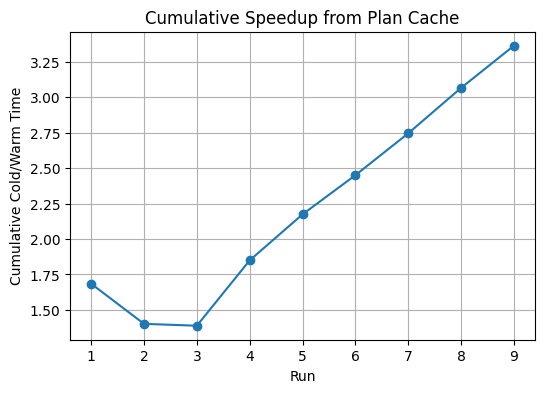

In [5]:
plt.figure(figsize=(6,4))
plt.plot(df['run'], df['cumulative_speedup'], marker='o')
plt.xlabel('Run')
plt.ylabel('Cumulative Cold/Warm Time')
plt.title('Cumulative Speedup from Plan Cache')
plt.grid(True)
plt.show()

In [6]:
import pandas as pd
from benchmarks.stats_utils import stats_table

def add_stats(df, quasar_col='QuASAr', baseline_cols=None, test='ttest', correction='bonferroni'):
    """Compute statistics comparing QuASAr with baselines.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with per-circuit results. One column must correspond to QuASAr,
        others to baselines.
    quasar_col : str
        Name of the column containing QuASAr results.
    baseline_cols : list[str] | None
        Columns to treat as baselines. Defaults to all columns except quasar_col.
    test : str
        'ttest' or 'wilcoxon'.
    correction : str
        'bonferroni' or 'fdr_bh'.

    Returns
    -------
    pd.DataFrame
        Table with baseline name, statistic, corrected p-value, and effect size.
    """
    if baseline_cols is None:
        baseline_cols = [c for c in df.columns if c != quasar_col]
    baselines = {c: df[c] for c in baseline_cols}
    return stats_table(df[quasar_col], baselines, test=test, correction=correction)

# Example usage after computing results DataFrame named `results_df`:
# stats_df = add_stats(results_df)
# stats_df


In [7]:

# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple))
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f"../results/{nb_name}_params.json", 'w') as f:
    json.dump(_params, f, indent=2, default=str)
if 'results' in globals():
    try:
        with open(f"../results/{nb_name}_results.json", 'w') as f:
            json.dump(results, f, indent=2)
    except TypeError:
        pass
print(json.dumps(_params, indent=2, default=str))


{
  "In": [
    "",
    "import time\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom qiskit import QuantumCircuit\nimport quasar\nimport quasar_convert as qconv\nfrom quasar.planner import Planner",
    "def build_circuit(theta1, theta2):\n    qc = QuantumCircuit(2)\n    qc.rx(theta1, 0)\n    qc.cx(0, 1)\n    qc.ry(theta2, 1)\n    return quasar.Circuit.from_qiskit(qc)",
    "angles = [(0.1,0.2), (0.3,0.4), (0.5,0.6)] * 3\nplanner_cold = Planner(quick_max_qubits=0)\nplanner_warm = Planner(quick_max_qubits=0)\nengine = qconv.ConversionEngine()\nmetrics = []\ncold_times = []\nwarm_times = []\nfor idx, (a,b) in enumerate(angles, start=1):\n    circ = build_circuit(a,b)\n    engine.extract_ssd([0,1], 2)\n    t0 = time.time(); planner_cold.plan(circ, use_cache=False); cold_times.append(time.time()-t0)\n    t0 = time.time(); planner_warm.plan(circ, use_cache=True); warm_times.append(time.time()-t0)\n    metrics.append({'run': idx,\n                    'cache_hits': planner_warm.ca

## Imported from `07_parallelism.ipynb`

# Parallelism Benchmarks
This notebook illustrates the effect of enabling scheduler parallel execution across backends.

In [ ]:
from quasar import Circuit, Scheduler
from quasar.cost import Backend
from quasar.planner import Planner
import time

circuit = Circuit([
    {"gate": "T", "qubits": [0]},
    {"gate": "T", "qubits": [1]},
    {"gate": "H", "qubits": [0]},
    {"gate": "H", "qubits": [1]},
])

class SleepBackend:
    def load(self, n):
        pass
    def apply_gate(self, gate, qubits, params):
        time.sleep(0.05)
    def extract_ssd(self):
        return None

scheduler_p = Scheduler(
    backends={Backend.DECISION_DIAGRAM: SleepBackend()},
    planner=Planner(),
    quick_max_qubits=None,
    quick_max_gates=None,
    quick_max_depth=None,
    parallel_backends=[Backend.DECISION_DIAGRAM],
)
start = time.time(); scheduler_p.run(circuit); par = time.time() - start

scheduler_s = Scheduler(
    backends={Backend.DECISION_DIAGRAM: SleepBackend()},
    planner=Planner(),
    quick_max_qubits=None,
    quick_max_gates=None,
    quick_max_depth=None,
    parallel_backends=[],
)
start = time.time(); scheduler_s.run(circuit); ser = time.time() - start
print(f"parallel {par:.3f}s vs serial {ser:.3f}s")


In [ ]:

# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple))
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f"../results/{nb_name}_params.json", 'w') as f:
    json.dump(_params, f, indent=2)
if 'results' in globals():
    try:
        with open(f"../results/{nb_name}_results.json", 'w') as f:
            json.dump(results, f, indent=2)
    except TypeError:
        pass
print(json.dumps(_params, indent=2))
